# CS294-112 Deep Reinforcement Learning HW1 Q3 Behavioral Cloning

Yifat Amir

### Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import tf_util
import gym
import sklearn.utils as sku
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import HTML, display

### Preparing the Data

In [2]:
def get_train_test_splits(obs_file, act_file, train_amount = None):
    print('loading expert observations and actions data')

    obs = np.load(obs_file).astype(np.float32)
    scaler = StandardScaler().fit(obs)
    obs = scaler.transform(obs).astype(np.float32)
    
    act = np.squeeze(np.load(act_file).astype(np.float32))
    
    if train_amount == None:
        return obs, None, act, None, scaler
    n_samples = obs.shape[0]
    obs_train, obs_test = train_test_split(obs, train_size = train_amount)
    act_train, act_test = train_test_split(act, train_size = train_amount)
    return obs_train, obs_test, act_train, act_test, scaler

### Hyperparameters

In [3]:
obs_file, act_file = ("obs_Ant-v1112809102017.npy", "act_Ant-v1112809102017.npy")
# ("obs_Hopper-v1044909042017.npy", "act_Hopper-v1044909042017.npy")
# ("obs_Humanoid-v1044209042017.npy", "act_Humanoid-v1044209042017.npy")
# ("obs_Ant-v1112809102017.npy", "act_Ant-v1112809102017.npy")
# ("obs_Reacher-v1113609102017.npy", "act_Reacher-v1113609102017.npy")
# ("obs_HalfCheetah-v1114209102017.npy", "act_HalfCheetah-v1114209102017.npy")
# ("obs_Walker2d-v1115109102017.npy", "act_Walker2d-v1115109102017.npy")
creature = "Ant"
num_iters = 20000
batch_size = 100
learning_rate = 0.001

### Train My Policy

In [4]:
sess = tf.InteractiveSession()
obs_train, obs_test, act_train, act_test, scaler = get_train_test_splits(obs_file, act_file)
print obs_train.shape
print act_train.shape
num_obs_features = obs_train.shape[1]
num_act_features = act_train.shape[1]

x = tf.placeholder(tf.float32, shape=[None, num_obs_features])
y_ = tf.placeholder(tf.float32, shape=[None, num_act_features])

layer1 = tf.contrib.layers.fully_connected(x, num_obs_features, activation_fn = tf.nn.tanh, weights_initializer=tf.contrib.layers.xavier_initializer())
layer2 = tf.contrib.layers.fully_connected(layer1, num_obs_features, activation_fn = tf.nn.tanh, weights_initializer=tf.contrib.layers.xavier_initializer())
y = tf.contrib.layers.fully_connected(layer2, num_act_features, activation_fn = None, weights_initializer=tf.contrib.layers.xavier_initializer())

policy_fn = tf_util.function([x], y)

loss = tf.nn.l2_loss(y_ - y) / batch_size

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
tf.global_variables_initializer().run()
losses = []
for i in range(num_iters):
    x_batch, y_batch = sku.shuffle(obs_train, act_train, n_samples = batch_size)
    a, loss_now = sess.run(fetches=[train_step, loss], feed_dict={x: x_batch, y_: y_batch})
    if (i % (num_iters/10) == 0):
        print "iter #", i
        losses.append(loss_now)

loading expert observations and actions data
(20000, 111)
(20000, 8)
iter # 0
iter # 2000
iter # 4000
iter # 6000
iter # 8000
iter # 10000
iter # 12000
iter # 14000
iter # 16000
iter # 18000


In [5]:
print losses

[1.5730798, 0.0041882098, 0.0021985422, 0.0022251981, 0.0017148277, 0.0018956367, 0.0014221952, 0.0012696092, 0.0014165604, 0.0014482593]


In [6]:
# correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# print sess.run(accuracy, feed_dict={x: obs_test, y_: act_test})

### Run My Policy

In [7]:
env = gym.make(creature + "-v1")
max_steps = env.spec.timestep_limit

returns = []
observations = []
actions = []
for i in range(20):
#     print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = policy_fn(scaler.transform(obs[None,:]).astype('float32'))
        observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
#         env.render()
#         if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            break
    returns.append(totalr)

print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

my_data = {'observations': np.array(observations),
               'actions': np.array(actions)}

[2017-09-10 23:40:06,247] Making new env: Ant-v1


('returns', [4828.8983074055695, 4831.0657919480209, 4871.5881312383444, 4690.9101505301323, 5021.2595768729643, 4928.2746530856039, 4880.8356549256059, 4812.5590721329954, 4754.5010128405293, 4637.6080232776903, 4770.1393127355605, 4861.814041478503, 4828.4675562487946, 4758.5004617430013, 4855.9849644054375, 4758.8032705891728, 4731.8348826969859, 4911.3045144043472, 4776.8819480952661, 5009.3720312597798])
('mean return', 4826.0301678957157)
('std of return', 94.683920861485731)


### Results

In [8]:
data = [["Task", "My Mean of Returns", "My SD of Returns", "Expert Mean of Returns", "Expert SD of Returns"],
         ["Ant", 4852.5017230854846, 74.23980300289098, 4782.1609172421513, 132.55560311907271],
         ["Walker2d", 4995.4266902009167, 1242.6555393075696, 5534.9265519203136, 44.500248612112557],
         ["Hopper", 1722.4381911703872, 1216.7809772698199, 3777.9972139025776, 3.2057125353927498],
         ["Reacher", -4.8619283516599729, 1.6960560957721855, -3.8987745270062617, 1.8182523276231009],
         ["Humanoid", 10385.595408411633, 52.941800608114725, 10411.367006191223, 64.386553835708511],
         ["HalfCheetah", 4049.217485821292, 92.03040403417107, 4158.3969968545998, 46.971685827755344],
         ]

display(HTML(
    '<table><tr>{}</tr></table>'.format('</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data))))


Task,My Mean of Returns,My SD of Returns,Expert Mean of Returns,Expert SD of Returns
Ant,4852.50172309,74.2398030029,4782.16091724,132.555603119
Walker2d,4995.4266902,1242.65553931,5534.92655192,44.5002486121
Hopper,1722.43819117,1216.78097727,3777.9972139,3.20571253539
Reacher,-4.86192835166,1.69605609577,-3.89877452701,1.81825232762
Humanoid,10385.5954084,52.9418006081,10411.3670062,64.3865538357
HalfCheetah,4049.21748582,92.0304040342,4158.39699685,46.9716858278


All tasks were run on a NN with two hidden layers, tanh activation, 20000 sample points, 20000 training iterations, batch size of 100, and learning rate of 0.001. Most tasks achieve comparable performance, except Hopper.

### Hyperparameter Tuning: Learning Rate

loading expert observations and actions data
training with learning rate: 1e-05


[2017-09-10 23:47:42,828] Making new env: Ant-v1


training with learning rate: 0.0001


[2017-09-10 23:49:12,298] Making new env: Ant-v1


training with learning rate: 0.001


[2017-09-10 23:50:35,083] Making new env: Ant-v1


training with learning rate: 0.01


[2017-09-10 23:52:00,258] Making new env: Ant-v1


training with learning rate: 0.1


[2017-09-10 23:53:28,583] Making new env: Ant-v1


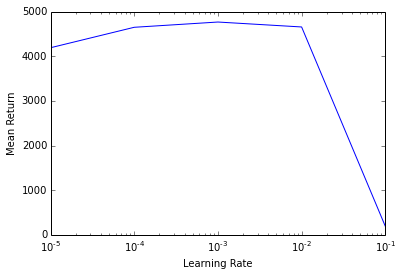

In [11]:
mean_returns = []
obs_train, obs_test, act_train, act_test, scaler = get_train_test_splits(obs_file, act_file)
num_obs_features = obs_train.shape[1]
num_act_features = act_train.shape[1]

lr_list = [0.00001, 0.0001, 0.001, 0.01, 0.1]
for learning_rate in lr_list:
    print "training with learning rate:", learning_rate
    sess = tf.InteractiveSession()
    
    x = tf.placeholder(tf.float32, shape=[None, num_obs_features])
    y_ = tf.placeholder(tf.float32, shape=[None, num_act_features])

    layer1 = tf.contrib.layers.fully_connected(x, num_obs_features, activation_fn = tf.nn.tanh, weights_initializer=tf.contrib.layers.xavier_initializer())
    layer2 = tf.contrib.layers.fully_connected(layer1, num_obs_features, activation_fn = tf.nn.tanh, weights_initializer=tf.contrib.layers.xavier_initializer())
    y = tf.contrib.layers.fully_connected(layer2, num_act_features, activation_fn = None, weights_initializer=tf.contrib.layers.xavier_initializer())

    policy_fn = tf_util.function([x], y)

    loss = tf.nn.l2_loss(y_ - y) / batch_size

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    tf.global_variables_initializer().run()
    for i in range(num_iters):
        x_batch, y_batch = sku.shuffle(obs_train, act_train, n_samples = batch_size)
        a, loss_now = sess.run(fetches=[train_step, loss], feed_dict={x: x_batch, y_: y_batch})
            
    env = gym.make(creature + "-v1")
    max_steps = env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(20):
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = policy_fn(scaler.transform(obs[None,:]).astype('float32'))
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if steps >= max_steps:
                break
        returns.append(totalr)

    mean_returns.append(np.mean(returns))
    
    sess.close()

plt.plot(lr_list, mean_returns)
plt.ylabel('Mean Return')
plt.xlabel('Learning Rate')
plt.xscale('log')
plt.show()

In [10]:
print creature

Ant


The graph above shows how performance varies with the value of the learning rate. I chose to experiment with this hyperparameter because it can greatly affect the optimization of the loss function. If the learning rate is too high, it is easy to overshoot a local optimum in the cost function. If the learning rate is too low, then it is hard to learn anything given a fixed number of training iterations.

### Appendix of Expert Returns

Hopper expert returns: 

('returns', [3771.9336598726591, 3774.6625045070514, 3779.9935082891625, 3771.5253685435282, 3777.3681930911616, 3778.839472656417, 3778.72690636986, 3780.420514438782, 3778.5508451495007, 3777.3928509435241, 3780.6255379793006, 3775.5027294050469, 3776.7569006634217, 3780.9128980517853, 3782.9810844516765, 3773.5071795005179, 3782.8216694611729, 3778.8721318571479, 3781.2896818439012, 3777.2606409759246])


('mean return', 3777.9972139025776)
('std of return', 3.2057125353927498)

Humanoid expert returns:

('returns', [10426.901581297876, 10354.999386314665, 10518.526981022384, 10362.961354650473, 10397.952862427941, 10446.38337188637, 10430.008532411424, 10393.84011458044, 10354.894427755571, 10462.98034042896, 10478.465784041504, 10294.904552806682, 10486.55218058908, 10467.231468828335, 10418.502544063733, 10508.646297411087, 10427.947459059114, 10364.952755875134, 10331.624674666315, 10299.063453707358])

('mean return', 10411.367006191223)
('std of return', 64.386553835708511)

Reacher expert returns:

('returns', [-4.186911948636455, -5.2678239265846116, -6.0242261321475707, -3.372837307792369, -4.1526844029394097, -4.8800377997838567, -3.7797431463669269, -1.7708528883578709, -7.7285160804080837, -1.9489484559423917, -6.678527275516446, -4.1668850712442085, -5.0495028527687227, -1.43408737401054, -0.82961070795971548, -3.5888372914308166, -1.5595323005597548, -2.5248902640517321, -5.6329022633401271, -3.3981330502836196])

('mean return', -3.8987745270062617)
('std of return', 1.8182523276231009)

Ant expert returns:

('returns', [4634.3406190538553, 4679.9912036002106, 4953.8808445439299, 4990.3345743233913, 4890.1763907943932, 4707.2176554932867, 4829.1796412666581, 4666.6558116610486, 4849.3110733590174, 4724.8338142283865, 4740.5009526333615, 4833.1880590325636, 4682.7170248359034, 4761.0720917128101, 4462.971570585778, 4938.5729851855885, 4712.6437039011062, 4748.6394716855511, 4814.7542912273575, 5022.2365657188247])

('mean return', 4782.1609172421513)
('std of return', 132.55560311907271)

HalfCheetah expert returns:

('returns', [4190.3812970932131, 4073.6968478036711, 4258.4218992211117, 4119.4144849436952, 4202.9336097251908, 4194.1485746829685, 4172.1107979342378, 4158.0410111130859, 4151.7562522970111, 4098.786746364889, 4080.2011038260184, 4191.3021620500786, 4170.7342197836688, 4146.3440854739783, 4108.9181177371765, 4201.9462925619591, 4143.5537391811922, 4198.9531821384571, 4110.7335363287693, 4195.561976831631])

('mean return', 4158.3969968545998)
('std of return', 46.971685827755344)

Walker2d expert returns:

('returns', [5585.2095384049071, 5460.791894766493, 5542.7623746208019, 5556.2732016421041, 5616.1747022383288, 5478.9192690510554, 5460.9133160694964, 5577.302376401778, 5527.9755056623562, 5599.083870098093, 5559.6238085367822, 5520.2790046826685, 5463.2838409422829, 5566.7195260477056, 5570.9962618069103, 5516.0585803941567, 5514.0024564038231, 5510.1747546902252, 5525.7448436481145, 5546.2419122981983])
('mean return', 5534.9265519203136)
('std of return', 44.500248612112557)